Solution of the robust performance problem via $\mu$-synthesis
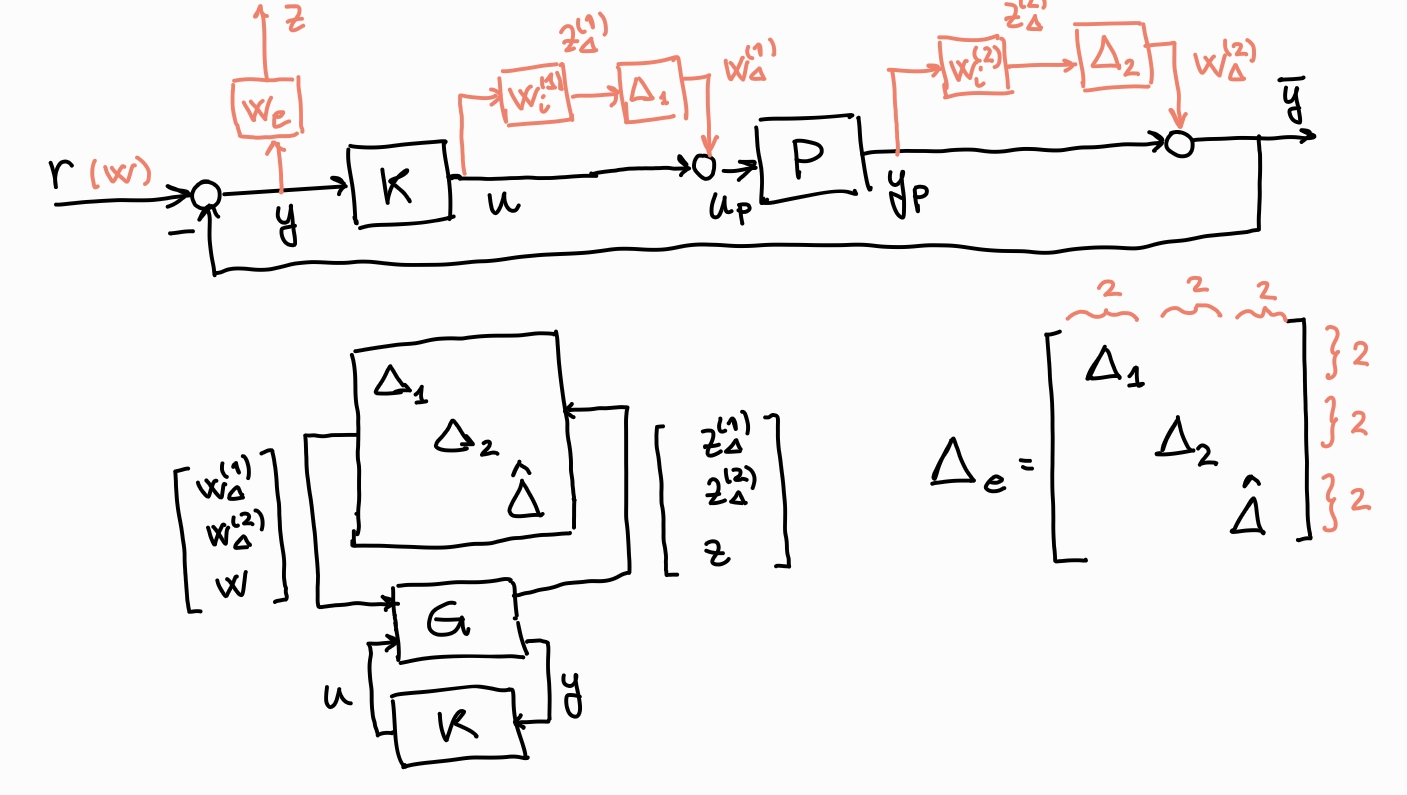

In [1]:
import matplotlib.pyplot as plt
from itertools import product
import slycot as sly
import numpy as np
import control as ct
import rpc_diism.robust as rb
s= ct.tf('s')

In [2]:
# Plant P
den = [0.2, 1.2, 1]
P = ct.tf([[[1], [1]],
              [[2, 1], [2]]],
             [[den, den],
              [den, den]])
display("Plant transfer function", P)

'Plant transfer function'

TransferFunction(
[[array([1]), array([1])],
 [array([2, 1]), array([2])]],
[[array([0.2, 1.2, 1. ]), array([0.2, 1.2, 1. ])],
 [array([0.2, 1.2, 1. ]), array([0.2, 1.2, 1. ])]],
outputs=2, inputs=2)

Define performance weight and uncertainty weight 

In [3]:
# Uncertainty block weight Wi1
Mi = 5
ei = 1e-4
wbi = 5 # Crossover frequency
Wi_1 = ct.ss(rb.weightU(wbi, Mi, ei, 1))
Wi1 = Wi_1.append(Wi_1) 

# Uncertainty block weight Wi2
Mi = 10
ei = 1e-4
wbi = 3 # Crossover frequency
Wi_1 = ct.ss(rb.weightU(wbi, Mi, ei, 1))
Wi2 = Wi_1.append(Wi_1) 

# Performance weight We (weight on S)
M = 10
e = 1e-4
wb = 0.1 # Crossover frequency
We_1 = ct.ss(rb.weightS(wb, M, e, 1))
We = We_1.append(We_1) 

Construct the LFT

In [4]:
Wi1.input_labels = ['u[0]', 'u[1]']
Wi1.output_labels = ['zdelta1[0]', 'zdelta1[1]']
Wi2.input_labels = ['yp[0]', 'yp[1]']
Wi2.output_labels = ['zdelta2[0]', 'zdelta2[1]']
We.input_labels = ['y[0]', 'y[1]']
We.output_labels = ['z[0]', 'z[1]']
P.input_labels = ['up[0]','up[1]']
P.output_labels = ['yp[0]','yp[1]']

# Summing junctions from uncertain blocks
sumdelta1 = ct.summing_junction(inputs=['u','wdelta1'], output='up', dimension=2)
sumdelta2 = ct.summing_junction(inputs=['yp','wdelta2'], output='ybar', dimension=2)

# Feedback: y = r-ybar
fbk = ct.summing_junction(inputs=['r','-ybar'], output='y', dimension=2)

# Generate the G transfer function of the LFT
G = ct.minreal(ct.interconnect([P, Wi1, Wi2, We, sumdelta1, sumdelta2, fbk],
                    inputs=['wdelta1[0]','wdelta1[1]','wdelta2[0]','wdelta2[1]','r[0]','r[1]','u[0]','u[1]'],
                    outputs=['zdelta1[0]','zdelta1[1]','zdelta2[0]','zdelta2[1]','z[0]','z[1]','y[0]','y[1]']), 
                    verbose=False)

Do $\mu$-synthesis

In [5]:
# Controller I/O sizes
f = 2

# Extended uncertainty structure: two 2x2 uncertainty blocks and a 2x2 performance block
nblock = np.array([2,2,2])
# This has to be == 2 (complex uncertainty) for each block (other values are not implemented)
itype = np.array([2,2,2])

# Frequency range for mu computations
omega = np.logspace(-3, 3, 151)

# Do mu-synthesis via D-K iteration
# Note that we enforce reduction on the closed loop of each iteration. If we don't, numerical problems arise
# for this problem instance
K, best_nubar, init_mubar, best_mubar, gamma = rb.musyn(G, f, nblock, itype, omega, initgamma=1e2, reduce=16)

display("Best upper bound (nubar) to mu norm of Tzw_delta: ", best_nubar)

Infinity norm of Tzw_delta with initial Hinfinity controller:  1.4318103402853
Iteration # 1
Best upper bound to mu norm of Tzw_delta:  1.0273061353638813
Iteration # 2
Best upper bound to mu norm of Tzw_delta:  0.9975873237348677
Iteration # 3
No better upper bound to mu norm of Tzw_delta found: trying D order  4 qutol  2
Iteration # 4
No better upper bound to mu norm of Tzw_delta found: trying D order  4 qutol  3
Iteration # 5
No better upper bound to mu norm of Tzw_delta found: trying D order  4 qutol  4
Iteration # 6
No better upper bound to mu norm of Tzw_delta found: trying D order  5 qutol  1
Iteration # 7
No better upper bound to mu norm of Tzw_delta found: trying D order  5 qutol  2
Iteration # 8
No better upper bound to mu norm of Tzw_delta found: trying D order  5 qutol  3
Iteration # 9
No better upper bound to mu norm of Tzw_delta found: trying D order  5 qutol  4
Iteration # 10
Best upper bound to mu norm of Tzw_delta:  0.931569147073752


'Best upper bound (nubar) to mu norm of Tzw_delta: '

0.931569147073752

Plot initial and final values of $\mu$ upper bound

Text(0.5, 1.0, 'Initial and final $\\bar\\mu$')

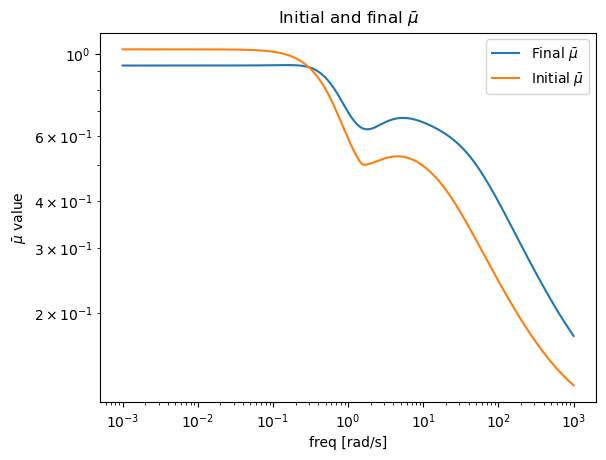

In [6]:
plt.loglog(omega, best_mubar, label=r'Final $\bar \mu$')
plt.loglog(omega, init_mubar, label=r'Initial $\bar \mu$')
plt.ylabel(r'$\bar\mu$ value')
plt.xlabel('freq [rad/s]')
plt.legend()
plt.title(r'Initial and final $\bar\mu$')

Verify performance on the nominal system. It must hold that $\|W_e S\|_\infty \leq \bar\nu$ for $\bar\nu=\sup_\omega \bar\mu$. 

Text(0.5, 1.0, 'Singular values of S vs. nubar*inv(We) for the nominal system')

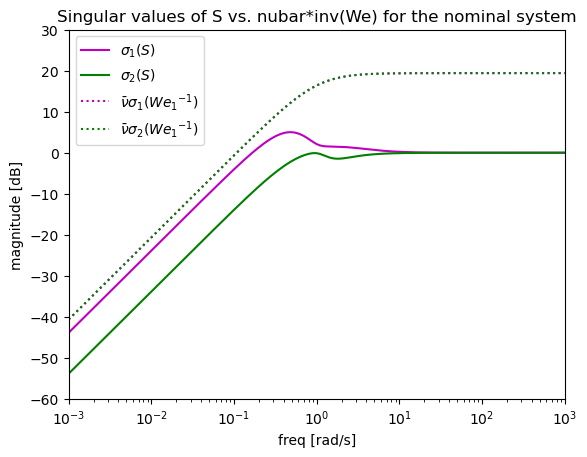

In [7]:
# Compute closed loop sensitivity for the nominal system
I = ct.ss([], [], [], np.eye(2)) # Identity system  
Delta1 = 0 * I
Delta2 = 0 * I
Delta1.input_labels = ['zdelta1[0]','zdelta1[1]']
Delta1.output_labels = ['wdelta1[0]','wdelta1[1]']   
Delta2.input_labels = ['zdelta2[0]','zdelta2[1]']
Delta2.output_labels = ['wdelta2[0]','wdelta2[1]'] 
K.input_labels = ['y[0]','y[1]']
K.output_labels = ['u[0]','u[1]'] 

S = ct.minreal(ct.interconnect([P, Delta1, Delta2, K, Wi1, Wi2, We, sumdelta1, sumdelta2, fbk],
                    inputs=['r[0]','r[1]'],
                    outputs=['y[0]','y[1]'], check_unused=False), verbose=False)

# Compute singular values of S over frequency
Ssv = rb.sigma(S, omega)

# We plot the singular values of gamma*invss(We) along with S
# for gamma = best_mu_upper_bound
Weinv = rb.invss(We)
Weinvsv = rb.sigma(Weinv, omega) * best_nubar

plt.semilogx(omega, 20*np.log10(Ssv[:, 0]), 'm', label=r'$\sigma_1(S)$')
plt.semilogx(omega, 20*np.log10(Ssv[:, 1]), 'g', label=r'$\sigma_2(S)$')
plt.semilogx(omega, 20*np.log10(Weinvsv[:, 0]), 'm:', label=r'$\bar\nu \sigma_1({We_1}^{-1})$')
plt.semilogx(omega, 20*np.log10(Weinvsv[:, 1]), 'g:', label=r'$\bar\nu \sigma_2({We_1}^{-1})$')
plt.ylim([-60, 30])
plt.ylabel('magnitude [dB]')
plt.xlim([1e-3, 1e3])
plt.xlabel('freq [rad/s]')
plt.legend()
plt.title('Singular values of S vs. nubar*inv(We) for the nominal system')

To demonstrate the importance of considering the structure in computing the robust performance controller, we solve the robust stability problem that is equivalent to robust performance using the small-gain theorem instead of $\mu$ (hence neglecting the structure ${\mathbf \Delta}_e$). This is done by computing an $H_\infty$ controller for robust stability. We compare the obtained controller with the $\mu$-synthesis controller on the nominal closed-loop. The level of performance $\|W_e S\|_\infty$ on the nominal system is slightly better for the controller designed ignoring the structure. Note that the $H_\infty$ problem is solved to the global optimum, while the solution of $\mu-$synthesis is suboptimal.

In [8]:
# Design the small-gain controller
KH, cl0, gamma, rcond = ct.hinfsyn(G, f, f)
KH.input_labels = ['y[0]','y[1]']
KH.output_labels = ['u[0]','u[1]'] 

# Compare the level of performance obtained by small gain and mu controllers
display("Gamma of the small gain controller: ", gamma)
display("Best nubar of the mu controller: ", best_nubar)

'Gamma of the small gain controller: '

1.501572974181283

'Best nubar of the mu controller: '

0.931569147073752

This clearly shows that the $\mu-$synthesis controller achieves a level of performance $\|W_e S\|_\infty \leq\bar\nu$ in an uncertainty set $\|\Delta\|_\infty < 1/\bar\nu$ which are respectively better and larger than the level of performance $\|W_e S\|_\infty \leq\gamma$ and uncertainty set $\|\Delta\|_\infty < 1/\gamma$ ensured by the small gain condition!

Now we verify the performance under a "random" perturbation satisfying the bound $\|\Delta\|_\infty = 1/ \bar\nu$, that is, on the boundary of the uncertainty set where the level of robust performance $\|W_e S\|_\infty \leq\bar\nu$ is guaranteed by the $\mu-$synthesis controller. We also compute the level of performance under the same perturbation for the controller computed using small gain, ignoring the structure of ${\mathbf \Delta}_e$.

Text(0.5, 1.0, 'Singular values of S vs. nubar*inv(We) for perturbed system')

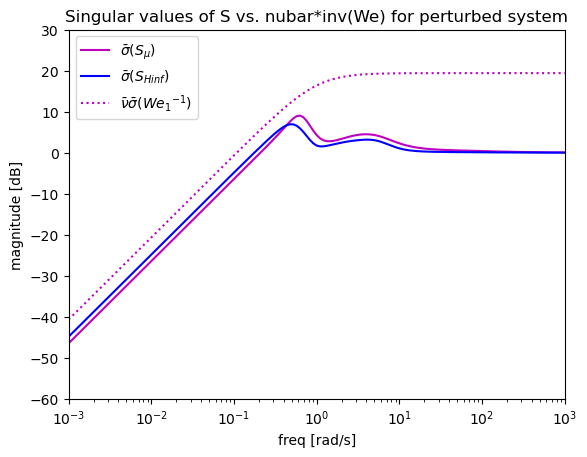

In [9]:
# Generate a perturbation on the boundary of the uncertainty set where the
# mu controller guarantees robust performance
Delta1 = 1/best_nubar * ct.ss((1-0.15*s)/(1+0.15*s))
Delta1 = Delta1.append(1/best_nubar * ct.ss((1-0.85*s)/(1+0.85*s)))
Delta2 = 1/best_nubar * ct.ss((1-0.4*s)/(1+0.4*s))
Delta2 = Delta2.append(1/best_nubar * ct.ss((1-0.5*s)/(1+0.5*s)))
Delta1.input_labels = ['zdelta1[0]','zdelta1[1]']
Delta1.output_labels = ['wdelta1[0]','wdelta1[1]']   
Delta2.input_labels = ['zdelta2[0]','zdelta2[1]']
Delta2.output_labels = ['wdelta2[0]','wdelta2[1]'] 

# Sensitivity under perturbation for mu controller
S = ct.minreal(ct.interconnect([P, Delta1, Delta2, K, Wi1, Wi2, We, sumdelta1, sumdelta2, fbk],
                    inputs=['r[0]','r[1]'],
                    outputs=['y[0]','y[1]'], check_unused=False), verbose=False)
# Sensitivity under perturbation for Hinf controller
SH = ct.minreal(ct.interconnect([P, Delta1, Delta2, KH, Wi1, Wi2, We, sumdelta1, sumdelta2, fbk],
                    inputs=['r[0]','r[1]'],
                    outputs=['y[0]','y[1]'], check_unused=False), verbose=False)

# Compute singular values of S over frequency
Ssv = rb.sigma(S, omega)
SHsv = rb.sigma(SH, omega)

# We plot the singular values of gamma*invss(We) along with S
Weinv = rb.invss(We)
Weinvsv = rb.sigma(Weinv, omega) * best_nubar

plt.semilogx(omega, 20*np.log10(Ssv[:, 0]), 'm', label=r'$\bar\sigma(S_\mu)$')
plt.semilogx(omega, 20*np.log10(SHsv[:, 0]), 'b', label=r'$\bar\sigma(S_{Hinf})$')
plt.semilogx(omega, 20*np.log10(Weinvsv[:, 0]), 'm:', label=r'$\bar\nu \bar\sigma({We_1}^{-1})$')
plt.ylim([-60, 30])
plt.ylabel('magnitude [dB]')
plt.xlim([1e-3, 1e3])
plt.xlabel('freq [rad/s]')
plt.legend()
plt.title('Singular values of S vs. nubar*inv(We) for perturbed system')

For this perturbation the controller computed neglecting the structure is unable to guarantee the level of performance $\|W_e S\|_\infty \leq\bar\nu$ that the $\mu$-synthesis one guarantees robustly, despite the fact that the $\mu-$synthesis solution is only suboptimal. This tells us that it is important to explicitly consider the structure!